## Run the sanity check on the streamable conv
1. run the vanilla (i.e., non-streamable) conv model in a one-go fashion.
2. run the vanilla (i.e., non-streamable) conv model in a streaming fashion.
3. run the streamable conv model in a streaming fashion.

Remarks
- inference runtime is measured.
- `chunk_size` determines the temporal length of the input to the model.
    - the non-streamable model is expected to perform badly on short chunk size, while the streamable model should.
- error is measured between the outputs of (1., 2.) and (1., 3.).

In [1]:
import os
os.chdir('../')

In [2]:
import os, random
import time
from typing import List

import numpy as np
import torch
import torch.nn as nn
import cached_conv as cc

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # determinism knobs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # cuBLAS reproducibility (PyTorch 1.10+ with CUDA 10.2+)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
    # use deterministic kernels where available
    torch.use_deterministic_algorithms(True, warn_only=True)


class AutoEncoder(nn.Module):
    def __init__(self, dim:int=128):
        super().__init__()
        kernel_size = (7,7)
        stride = (2,2)
        padding = ((kernel_size[0]-1)//2, (kernel_size[1]-1)//2)
        self.encoder = cc.Sequential(
            cc.Conv2d(1, dim, kernel_size, stride=stride, padding=padding), nn.Tanh(),
            cc.Conv2d(dim, dim, kernel_size, stride=stride, padding=padding), nn.Tanh(),
            cc.Conv2d(dim, dim, kernel_size, stride=stride, padding=padding), nn.Tanh(),
            # cc.Conv2d(dim, dim, kernel_size, stride=stride, padding=padding), nn.Tanh(),
            # cc.Conv2d(dim, dim, kernel_size, stride=stride, padding=padding), nn.Tanh(),
            # cc.Conv2d(dim, dim, kernel_size, stride=stride, padding=padding), nn.Tanh(),
            cc.Conv2d(dim, 1, kernel_size, stride=stride, padding=padding)
        )
        self.total_stride = 2**7  # 2**n_strides
        self.apply(self._init_weights)

    def _init_weights(self, m):
        # cc.Conv1d/ConvTranspose1d usually subclass nn.Conv*, but be robust:
        if hasattr(m, "weight") and isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)) or m.__class__.__name__ in {"Conv1d","ConvTranspose1d"}:
            # Xavier is recommended for tanh
            gain = nn.init.calculate_gain('tanh')
            nn.init.xavier_uniform_(m.weight, gain=gain)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.encoder(x)


def k_folds_by_size(x: torch.Tensor, chunk_size: int, dim: int = -1, drop_last: bool = False) -> List[torch.Tensor]:
    """
    Split `x` into non-overlapping chunks of length `chunk_size` along `dim`.
    The final chunk may be shorter unless `drop_last=True`.

    Args:
        x: input tensor (e.g., waveform shaped (1, T) or (B, T)).
        chunk_size: positive integer length for each chunk.
        dim: dimension to split along (default: time axis at -1).
        drop_last: if True, discard a final shorter chunk.

    Returns:
        List[Tensor]: chunks along `dim`.
    """
    if chunk_size <= 0:
        raise ValueError("chunk_size must be a positive integer")

    chunks = list(torch.split(x, chunk_size, dim=dim))
    if drop_last and chunks and chunks[-1].size(dim) < chunk_size:
        chunks.pop()
    return chunks

In [3]:
cc.use_cached_conv(False)  # must be defined before creating the model instance
set_seed(1234)
model = AutoEncoder()

### inference with vanilla convs

In [75]:
import torch
import torchaudio

# wav, sr = torchaudio.load('audio_samples/VO HAC Riedel V2 Clean.wav')
# wav = wav.mean(dim=0, keepdim=True)
# target_sr = 24000
# wav = torchaudio.functional.resample(wav, sr, target_sr)
# sr = target_sr

# n_fft = 1024
# hop_length = 256
# win_length = 1024
# n_mels = 80
# window = torch.hann_window(win_length)
# spec = torch.stft(wav, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, return_complex=True)
# mag_spec = torch.abs(spec)
# mel_fbank = torchaudio.functional.melscale_fbanks(mag_spec.shape[-2], 0, n_fft, n_mels=n_mels, sample_rate=sr)
# print('mag_spec.shape:', mag_spec.shape)
# print('mel_fbank.shape:', mel_fbank.shape)
# mel_spec = (mag_spec.transpose(1, 2) @ mel_fbank).transpose(1, 2)
# log_mel_spec = torch.log10(mel_spec + 1e-6)
# log_mel_spec = log_mel_spec.unsqueeze(1)  # create a dummy channel dim

# print('wav.shape:', wav.shape)
# print('log_mel_spec.shape:', log_mel_spec.shape)


sr = 24000
length = sr * 2
x_rng = torch.linspace(0, length, length//2).unsqueeze(0).unsqueeze(0)  # (b, c, t)
wav = torch.sin(x_rng) + 0.5*torch.sin(x_rng * 10 + 0.5) + 2*torch.sin(x_rng * 0.1 + 1.2)
log_mel_spec = wav.repeat(1, 80, 1).unsqueeze(1)  # (b 1 f t)

log_mel_spec.shape: torch.Size([1, 1, 80, 24000])
out.shape: torch.Size([1, 1, 5, 1500])
vmin: -0.124, vmax: 0.168


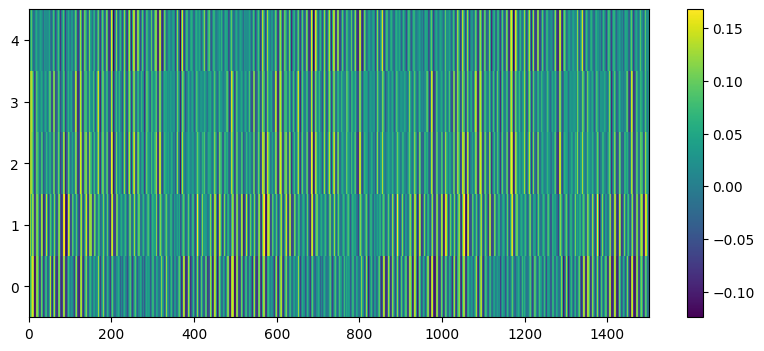

In [76]:
# one-go inference

with torch.no_grad():
    out = model(log_mel_spec)
out_gt = out.clone()
out_gt = out_gt.squeeze().detach().numpy()

print('log_mel_spec.shape:', log_mel_spec.shape)
print('out.shape:', out.shape)

# plot the output
import matplotlib.pyplot as plt
data = out.squeeze().detach().numpy()
vmin, vmax = data.min(), data.max()
print(f"vmin: {vmin:.3f}, vmax: {vmax:.3f}")

plt.figure(figsize=(10, 4))
plt.imshow(data, origin='lower', aspect='auto', interpolation='none', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

In [77]:
# split the input into chunks
chunk_size = model.total_stride * 6
chunks = k_folds_by_size(log_mel_spec, chunk_size=chunk_size, dim=-1)

print('len(chunks):', len(chunks))
print('chunks[0].shape:', chunks[0].shape)

len(chunks): 32
chunks[0].shape: torch.Size([1, 1, 80, 768])


out.shape: (5, 1500)


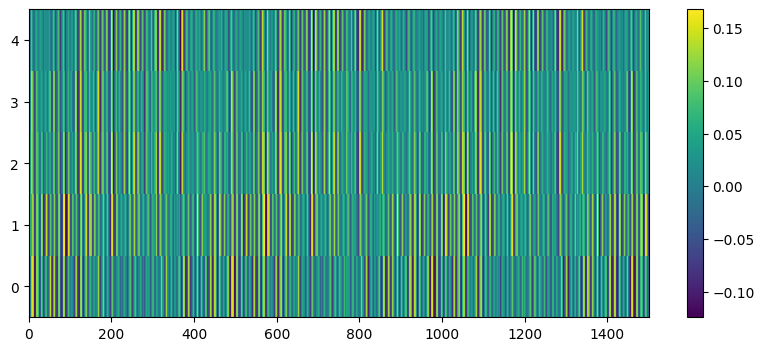

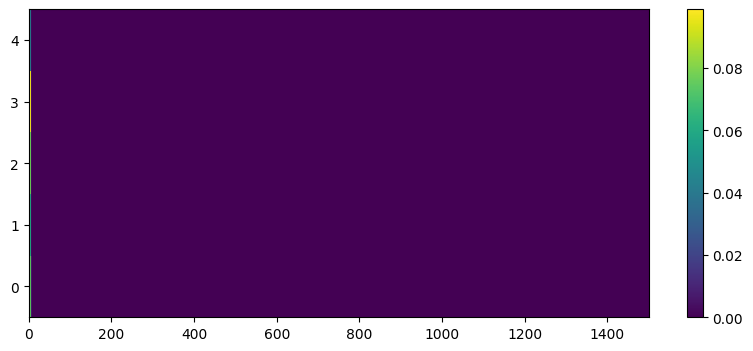

--------------------
[vanilla convs]
chunk_size: 768
duration of the chunk_size: 0.03 [s]
runtime: 0.9096
sum(abs(err)): 1.3254826
--------------------


In [78]:
# streaming inference

# run the inference on each chunk in a streaming fashion
st_time = time.time()
outs = []
for i, fold in enumerate(chunks):
    with torch.no_grad():
        out = model(fold)  # (1 f t)
    outs.append(out)
out = torch.cat((torch.cat(outs[:-1], dim=-1), outs[-1]), dim=-1)
out = out.squeeze().detach().numpy()
print('out.shape:', out.shape)
end_time = time.time()

# plot the output
plt.figure(figsize=(10, 4))
plt.imshow(out, origin='lower', aspect='auto', interpolation='none', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

# plot the abs error
plt.figure(figsize=(10, 4))
err = np.abs(out_gt - out)
plt.imshow(err, origin='lower', aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

# log
print('--------------------')
print('[vanilla convs]')
print('chunk_size:', chunk_size)
print('duration of the chunk_size:', round(chunk_size / sr, 2), '[s]')
print('runtime:', round(end_time - st_time, 4))
print('sum(abs(err)):', np.sum(np.abs(err)))
print('--------------------')

### inference with streamable convs

In [79]:
cc.use_cached_conv(True)  # must be defined before creating the model instance; streamable convs
set_seed(1234)
model = AutoEncoder()

1. out.shape: torch.Size([5, 1500])
out_gt.shape: (5, 1500)
2. out.shape: torch.Size([5, 1500])


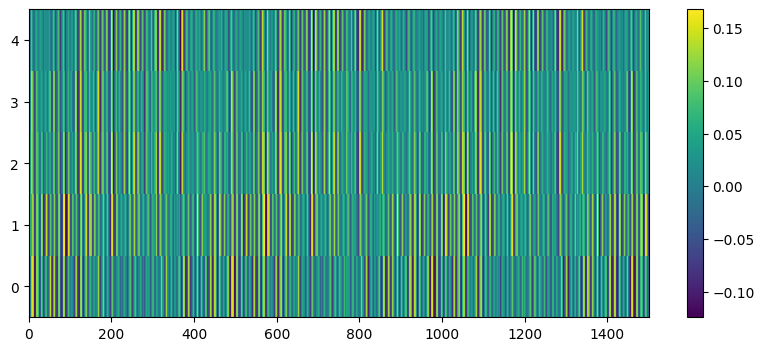

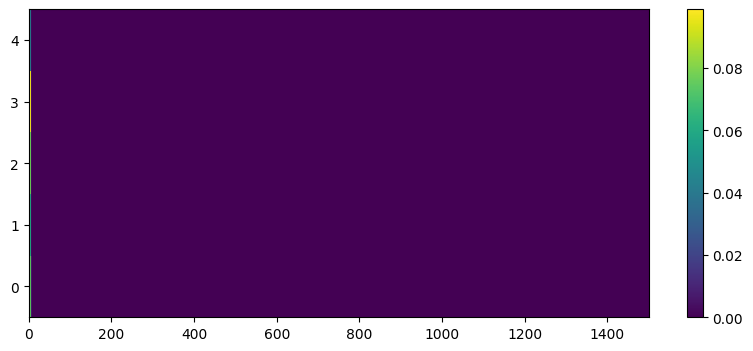

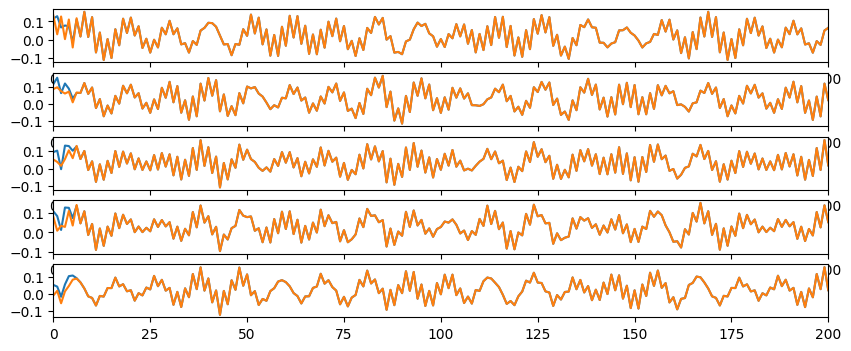

--------------------
[vanilla convs]
chunk_size: 768
duration of the chunk_size: 0.03 [s]
runtime: 0.8591
sum(abs(err)): 1.3254826
--------------------


In [83]:
# streaming inference

# run the inference on each chunk in a streaming fashion
st_time = time.time()
outs = []
for i, fold in enumerate(chunks):
    with torch.no_grad():
        out = model(fold)  # (1 f t)
    outs.append(out)
out = torch.cat((torch.cat(outs[:-1], dim=-1), outs[-1]), dim=-1)
out = out.squeeze().detach() #.numpy()
print('1. out.shape:', out.shape)
end_time = time.time()

# automatically get the right-sized padding to compensate for the intermal delay (this delay exists for non-causal conv layers)
# left_pad_size = 0
# errs = []
# for i in range(10):
#     MIN_LEN = min(out_gt.shape[-1], out.shape[-1])
#     left_pad_size_ = i
#     out_ = torch.cat((torch.zeros_like(out)[...,:left_pad_size_], out), dim=-1)
#     out_ = out_.numpy()
#     err = out_gt[...,:MIN_LEN] - out_[...,:MIN_LEN]
#     err = np.sum(np.abs(err))
#     errs.append(err)
# idx = np.argmin(errs)
# left_pad_size = np.arange(10)[idx]
# out = torch.cat((torch.zeros_like(out)[...,:left_pad_size], out[...,:-left_pad_size]), dim=-1)
print('out_gt.shape:', out_gt.shape)
print('2. out.shape:', out.shape)

# plot the output
plt.figure(figsize=(10, 4))
plt.imshow(out, origin='lower', aspect='auto', interpolation='none', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

# plot the abs error
plt.figure(figsize=(10, 4))
err = np.abs(out_gt - out.numpy())
plt.imshow(err, origin='lower', aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

# plot
xlim = (0, 200)
plt.figure(figsize=(10, 4))
n_plots = 5
for idx in range(n_plots):
    plt.subplot(n_plots, 1, idx+1)
    plt.plot(out_gt[idx])
    plt.plot(out[idx])
    plt.xlim(*xlim)
plt.show()


# log
print('--------------------')
print('[vanilla convs]')
print('chunk_size:', chunk_size)
print('duration of the chunk_size:', round(chunk_size / sr, 2), '[s]')
print('runtime:', round(end_time - st_time, 4))
print('sum(abs(err)):', np.sum(np.abs(err)))
print('--------------------')

In [81]:
print(out_gt.shape)
print(out.shape)

(5, 1500)
torch.Size([5, 1500])
